# RL coursework, part IV (30 pts in total)

---

**SN:** 15066212

---

**Due date:** *29th March, 2022, - EC apply*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part4.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

### Objectives

#### Q.1: You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.

#### Q.2: You will be looking at other, TD-like, updates to learn the value function. You will be asked to investigate different properties of these: e.g. convergence properties, variance of updates. This is akin to a typical analysis one would undertaken when proposing a new update rule to learn value functions.


## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

## Q1 [11 points total]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency. 

In [3]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  del pi
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
    
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 1.1 [5 points]
Implement the return functions below and run the cells below that.

In [7]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with full importance-sampling corrections, so that
  the return G_t is corrected with the full importance-sampling correction of
  the rest of the trajectory.
  """
  # Follow the initialisation in the examples above:
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))

  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # Calculate the multi-step returns
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])

  # When applying the full importance-sampling correction, 
  # we multiply the returns by the product of the policy ratios for every action in the episode
  # from the current time step to the penultimate time step (the one before the terminating stage)
  rho = 1 # initialise importance-sampling ratio
  # Note that we couldn't do this inside the first for loop bc when we calculate the returns we use the future returns
  # So we could not apply the correction yet. We apply the correction once all the returns are calculated.
  for t in reversed(range(T)):
    rho *= pi[t] / mu[t]
    G[t] *= rho # apply correction to the return

  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  
  return (1 - l)*v + l*G


def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with per-decision importance-sampling corrections.
  """
  # Follow the initialisation in the examples above:
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))

  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # Calculate the multi-step returns
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
      # G[t] *= pi[t] / mu[t] # apply importace sampling correction -- NO
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
      # G[t] *= pi[t] / mu[t] # apply importace sampling correction -- NO
  
  for t in reversed(range(T)):
    rho = pi[t] / mu[t]
    G[t] *= rho # apply correction to the return
  # Note that we couldn't do this inside the first for loop bc when we calculate the returns we use the future returns
  # So we could not apply the correction yet. We apply the correction once all the returns are calculated.

  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  
  return (1 - l)*v + l*G


def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
    
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    error *= pi[t] / mu[t]
    errors[t] = error
  
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns

  return v + l*errors


def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates, and
  3. adaptive bootstrapping.

  Implement the adaptive bootstrapping with an *additional* trace parameter
  lambda, such that lambda_t = lambda * min(1, 1/rho_t).
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
    
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    rho = pi[t] / mu[t]
    l_t = np.minimum(1, 1/rho)
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    error *= l_t*rho
    errors[t] = error

  v = v[:-1]  # Remove (T+1)th observation before calculating the returns

  return v + l*errors

In [8]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...
  
  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=np.int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state

  # in this case, observations are just the real states
  observations = states

  # generate rewards
  rewards     = 2.*actions - 1. # -1 for left, +1 for right, 
  rewards[-1] = np.sum(actions)  # extra final reward for going right
    
  # compute discounts
  discounts     = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0

  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities
    
  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



<ipython-input-8-140ce01515e4>:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


[ 19.728 714.759  26.933   5.341   0.778]


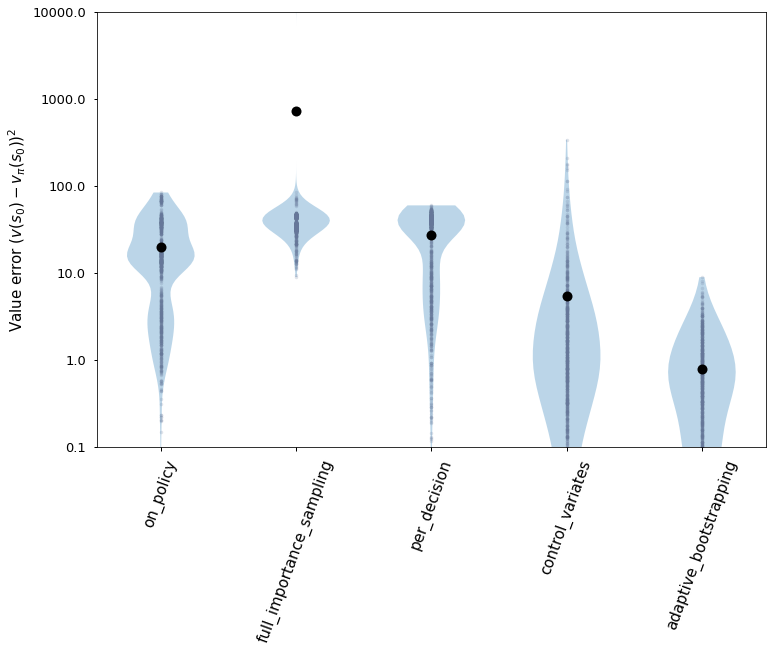

In [9]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision', 'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise 

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 1.2 [3 points]
Explain the ranking in terms of value error of the different return estimates.

When doing importance-samplong, the variance of the expected reward in the off-policy case is much larger than in the on-policy case due to the second moment term $E(X^{2})$. This results in larger error in the estimated state values.

In full importance-sampling, the correction we apply to each return at time step 't' contains the product of the policy ratio of all subsequent states, even though later states do not affect earlier actions. For this reason, the variance in the expected returns is very high, and therefore, the mean squared value error is the highest. To improve that, in pre-decision importance-sampling, we assume the rewards and the policy ratio are uncorrelated, and so we can cut out the actions after we have received the reward when calculating the importance sampling ratio (we only consider the current action), and since the ratio is calculated considering a shorter trajectory, it might have lower variance, resulting in a reduction of the mean squared value errors.

In control variates we introduce the covariant term, whoich can be interpreted as a term that reduces the variance of the updates but does not change the expectation. This is done using multi-step returns via a trace parameter $\lambda$, which interpolates between a bootstrapping target and the Monte Carlo target when calculating the return, introducing some bias. This appears to have even lower mean squared value errors than on-policy learning in this experiment.

Finally, adaptive bootstrapping introduces a time-dependent bootstrap parameter $\lambda_{t}$ to the control variates expression, which chooses how much we are bootstrapping in each time step, depending on whether we are very off-policy (i.e. $\rho$ ratio is far from 1), or the target and behaviour policy act similarly (i.e. $\rho$ ratio is closer to 1). In other words, the bootstrap parameter limits the amount we bootstrap when we are very off-policy to avoid divergence due to a deadly triad, which is why it results in the lowest mean squared value errors, because it bootstraps when we can to reduce variance, but it does not when it would cause divergence.



### Q 1.3 [3 points]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

Yes, choosing adaptive bootstrapping can be dangerous and cause divergence when we combine it with function approximation and off-policy learning (deadly triad). In the above experiment we did not do function approximation, so that is why adaptive bootstrapping yielded the best results. However, in the case of a deadly triad, if we bootstrap too much, the results could diverge and result in very large errors. In that case, we might be better off using other types of return that have less bootstrapping, such as control variates with $\lambda$ close to 1.

## Q2 [19 points total]
 Consider a MDP $M = (\mathcal{S}, \mathcal{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:




### Q2.1 [9 points]
Consider a learning update based on the following temporal difference error:
$$\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$

Consider updating a tabular action value function with TD.

i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under fixed behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 points)

ii) Under which conditions, would the above process converge to the optimal value function $q_*$ ? (2 points)

Note that the above is an example of a Q-learning algorithm. Therefore, we refer to the a paper by Francisco S. Merlo, "Convergence of Q-learning: a simple proof" to answer the questions (i) and (ii). See the paper in the link: http://users.isr.ist.utl.pt/~mtjspaan/readingGroup/ProofQlearning.pdf 

The answers to questions (i) and (ii) are in the image attached below, since the work has been hand-written due to the large amount of notation needed for the proof, which is hard to code in a markdown.

![Q2.1 page 1](NB4_Q2_1_page1.jpg)
![Q2.1 page 2](NB4_Q2_1_page2.jpg)

### Q2.2 [10 points]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$ and consider the behaviour policy to be either:

  a. $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$,
  
  b. $\mu(a|s) = \frac{1}{|\mathcal{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (4 points)
* ii) How does the variance of this update compare to the one induced by the error in Q2.1? (3 points). 
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)

- (i) In the case (a), the bahviour policy $\mu$ is the same as the target policy $\pi$, and therefore, we would be doing on-policy learning. This would yield the same case for the action value function as the one derived in Q2.1, where we saw that the action value function would converge as long as all state-action pairs (S,A) are visited infinitely often. However, looking at the policy, this is not the case, since we have a greedy policy. In this case, we would not have enough exploration for the values to converge, since as soon as one action value would be updated to a larger value than the initiated action values (usually initial values are set to zero), the policy would get stuck exploiting that greedy action, ignoring any other actions that might actually be better in the long run.
In the case (b), the behaviour and target policy are different, meaning that we do off-policy learning. Therefore, we need to apply corrections to the returns in order to obtain their unbiased estimate value under the target policy. We can show that the estimate return under the behaviour policy is already unbiased under the target policy:

![Q2.1 part (i)](NB4_Q2_2.jpg)

Therefore, the action value function will converge to the optimal value, since the action policy acts greedily, and the behaviour policy ensures exploration by uniformly sampling actions.

- (ii) The variance for the on-policy case (a) is already derived in question Q2.1. For the off-policy case (b), the importance-sampling ratio $\pi / \mu$ will be 0 / (1/|A|) = 0 for the non-greedy actions, and 1 / (1/|A|) = |A| for the greedy action. Therefore, the updates will jump between two different values influenced by this ratio, and hence, the variance will be larger than in the on-policy case.

- (iii) To reduce variance in the value updates, we need to propose a behaviour policy that will result in an importance-sampling ratio that does not vary much when considering the greedy action or any non-greedy action. However, I do not see what option we could propose other than the already proposed greedy behaviour policy (on-policy learning) that ensures that the correction ratio is always one and this way we do not update towards different values when choosing greedy or non-greedy actions. Another option would be to find a behaviour policy that would make the ratio 0, so that the update is always towards zero, which would not converge to the optimal right action value, but at least it would reduce the variance in the updates, which is what we are asked here. However, I cannot think of a behaviour policy that could achieve that, since when the target policy chooses a non-greedy action, its probability is low, so the probability of the behaviour policy to choose that action should be large to reduce the ratio to zero. But when the target policy chooses the greedy action, the probability is high, so we would still need the behaviour policy to pick that action with an even higher probability, which does not seem realistic.